<center style="font-size: 26px"> <b>Проверка уровня знаний Python</b></center>

In [7]:
# обеспечиваем совместимость с Python 2 и 3
from __future__ import (absolute_import, division, print_function, unicode_literals)

# отключаем предупреждения дистрибутива Anaconda
import warnings
warnings.simplefilter('ignore')

**Описание датасета:**   
[Датасет вакансий с платформы HH.ru на Kaggle.com](https://www.kaggle.com/datasets/pavfedotov/heaadhunter-vacancies?resource=download&select=df2021-08-03.csv) 

Нужный файл - df2021-08-03.csv.

- *vacancy* - наименование вакансии
- *url* - ссылка на вакансию
- *created* - дата и время создания
- *has_test* - наличие тестового задания в вакансии
- *salary_from* - нижняя граница значения заработной платы
- *salary_to* - верхняя граница значения заработной платы
- *currency* - валюта заработной платы
- *experience* - требуемый опыт
- *schedule* - тип рабочего графика
- *skills* - требуемые навыки
- *employer* - наименование работодателя
- *area* - наименование города
- *description* - описание вакансии

#### Загрузите датасет

In [27]:

import pandas as pd

df = pd.read_csv('df2021-08-03.csv')

In [28]:
df['created'] = pd.to_datetime(df['created'], format='%Y-%m-%dT%H:%M:%S%z')
df['created'] = df['created'].dt.strftime('%Y-%m-%d %H:%M:%S')

In [10]:
df[:2]

,vacancy,url,created,has_test,salary_from,salary_to,currency,experience,schedule,skills,employer,area,description
0,Backend/Full-stack developer (python),https://hh.ru/applicant/vacancy_response?vacan...,2021-08-01 13:02:48,False,120000.0,NaN,RUR,От 1 года до 3 лет,Гибкий график,Python;PostgreSQL;Linux;Flask;,ATI.SU,Санкт-Петербург,Привет! Мы ATI.SU ― крупнейшая в России компан...
1,Бэкенд-разработчик (Python) / Middle Python / ...,https://hh.ru/applicant/vacancy_response?vacan...,2021-07-09 08:13:01,False,150000.0,220000.0,RUR,От 3 до 6 лет,Удаленная работа,Python;Git;MongoDB;Redis;Design Patterns;Flask;,"ЮТэйр, Авиакомпания",Киров (Кировская область),Utair - российская авиакомпания. Мы летаем по ...


In [11]:
df['currency'].unique()

array(['RUR', nan, 'EUR', 'USD'], dtype=object)

### Практические задания:

#### 1. Изучите методы для сбора данных курсов валют в [API Центрального банка Российской Федерации](https://www.cbr.ru/development/SXML/) . Используя запросы к API, приведите значения заработной платы к рублям одним из вариантов: 1) простой вариант - на текущую дату  2) вариант посложнее - на дату создания (created).

In [29]:

import requests
import numpy as np
from datetime import datetime

# Функция для получения курса валют на дату
def get_currency_rate(date):
    url = f'http://www.cbr.ru/scripts/XML_daily.asp?date_req={date}'
    response = requests.get(url)
    response.encoding = 'utf-8'
    content = response.text
    rate = content.split('<Valute ID="R01235">')[1].split('<Value>')[1].split('</Value>')[0]
    return float(rate.replace(',', '.'))

# Функция для преобразования зарплаты в рубли на основе курса валют
def convert_salary_to_rubles(salary_from, salary_to, currency, created):
    if currency == 'RUR':
        return np.nanmean([salary_from, salary_to])
    elif pd.isna(currency):
        return None
    else:
        try:
            rate_date = datetime.strptime(created, '%Y-%m-%d %H:%M:%S').strftime('%d/%m/%Y')
            rate = get_currency_rate(rate_date)
        except:
            return None
        if currency == 'USD':
            return round(np.nanmean([salary_from, salary_to]) * rate, 2)
        elif currency == 'EUR':
            return round(np.nanmean([salary_from, salary_to]) * rate, 2)    
        else:
            return None

# Создание нового столбца с зарплатой в рублях
df['mean_salary_rub'] = df.apply(lambda x: convert_salary_to_rubles(x['salary_from'], x['salary_to'], x['currency'], x['created']), axis=1)


In [13]:
df[df['currency'] == 'USD'][:1]

,vacancy,url,created,has_test,salary_from,salary_to,currency,experience,schedule,skills,employer,area,description,mean_salary_rub
142,"Python Developer (Люксембург, удаленно)",https://hh.ru/applicant/vacancy_response?vacan...,2021-07-30 13:09:00,False,NaN,3500.0,USD,От 3 до 6 лет,Удаленная работа,Python;,Кадровое агентство Алексея Сухорукова,Новосибирск,"IT-компания, которая предоставляет своим клиен...",256166.4


#### 2. Найдите вакансию с самой высокой заработной платой, где подойдет 4 года опыта работы и не нужно проходить тестовое задание.

In [30]:
import re

# Приведение значений столбца experience к строковому типу
df['experience'] = df['experience'].astype(str)

# Создание столбца experience_min
df['experience_min'] = df['experience'].apply(lambda x: re.findall('\d+', x)[0] if re.findall('\d+', x) else None)

# Приведение значений столбца experience_min к числовому типу
df['experience_min'] = pd.to_numeric(df['experience_min'], errors='coerce')

# Выборка вакансий с опытом работы не более 4 лет
df_filtered = df[(df['experience_min'] <= 4) & (df['has_test'] == False)]

# Удаление строк с пропущенными значениями зарплаты
df_filtered.dropna(subset=['experience_min'], inplace=True)

# найти вакансию с самой высокой зарплатой
highest_salary = df_filtered.loc[df_filtered['mean_salary_rub'].idxmax()]

# вывести информацию о вакансии с самой высокой зарплатой
print("Вакансия с наибольшей средней зарплатой:")
print(highest_salary['vacancy'])
print(highest_salary['url'])
print(highest_salary['mean_salary_rub'], "руб.")


Вакансия с наибольшей средней зарплатой:
Python разработчик (middle) (backend)
https://hh.ru/applicant/vacancy_response?vacancyId=43941903
500000.0 руб.


#### 3. Сделайте рейтинг (топ-30) навыков по всем вакансиям.

In [31]:
befor_len = len(df.columns)

skills_set = set()
for skills in df['skills']:
    if isinstance(skills, str):
        skills_list = skills.split(';')
        skills_set.update(skills_list)

skills_set.discard('')
len_skills = len(skills_set)
for skill in skills_set:
    df[skill] = df['skills'].apply(lambda x: int(skill in x.split(';')) if isinstance(x, str) else 0)
for skill in skills_set:
    df[skill + '_freq'] = df.apply(lambda row: row[skill] / sum(x for x in row[skills_set] if x) if row[skill] != 0 else 0, axis=1)
for skill in skills_set:
    df[skill + '_a_salary'] = df[skill] * df['mean_salary_rub']
for skill in skills_set:
    df[skill + '_f_salary'] = df[skill + '_freq'] * df['mean_salary_rub']

skills_count_top = df.iloc[:, befor_len:(len_skills+befor_len)].sum().sort_values(ascending=False).reset_index().rename(columns={0: 'Количество'})
skills_freq_top = df.filter(regex='_freq$').mean().sort_values(ascending=False).reset_index().rename(columns={0: 'Частота'})
skills_a_salary_top = df.filter(regex='_a_salary$').mean().sort_values(ascending=False).reset_index().rename(columns={0: 'Абсолютная стоимость'})
skills_f_salary_top = df.filter(regex='_f_salary$').mean().sort_values(ascending=False).reset_index().rename(columns={0: 'Относительная стоимость'})
skills_freq_top['index'] = skills_freq_top['index'].str.replace('_freq', '')
skills_a_salary_top['index'] = skills_a_salary_top['index'].str.replace('_a_salary', '')
skills_f_salary_top['index'] = skills_f_salary_top['index'].str.replace('_f_salary', '')
skills_count_top['rank'] = list(reversed(range(1, (len_skills+1))))
skills_freq_top['rank'] = list(reversed(range(1, (len_skills+1))))
skills_a_salary_top['rank'] = list(reversed(range(1, (len_skills+1))))
skills_f_salary_top['rank'] = list(reversed(range(1, (len_skills+1))))
skills_count_top = skills_count_top.set_index('index')
skills_freq_top = skills_freq_top.set_index('index')
skills_a_salary_top = skills_a_salary_top.set_index('index')
skills_f_salary_top = skills_f_salary_top.set_index('index')
top_skills = pd.concat([skills_count_top, skills_freq_top, skills_a_salary_top, skills_f_salary_top], axis=1, join='outer')
top_skills['total_score'] = top_skills['rank'].sum(axis=1)

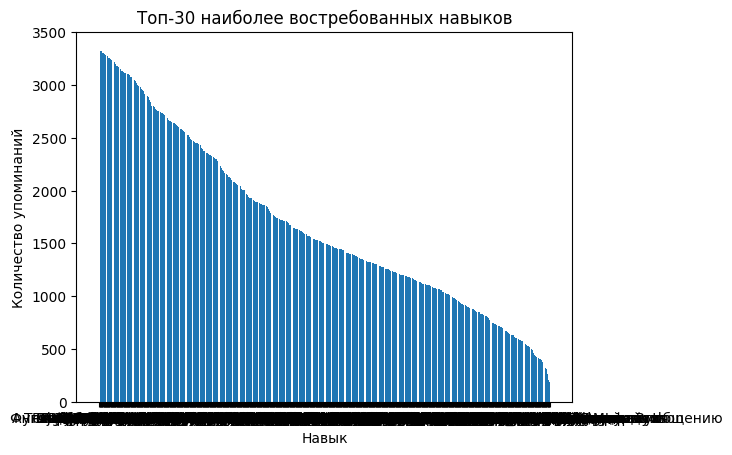

In [43]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import display, HTML

top_30_skills = top_skills.sort_values('total_score', ascending=False)
a = (top_30_skills['total_score'].max()/100)

# Строим график
fig, ax = plt.subplots()
ax.bar(top_30_skills.index, top_30_skills['total_score'])

# Добавляем подписи к осям и заголовок
ax.set_xlabel('Навык')
ax.set_ylabel('Количество упоминаний')
ax.set_title('Топ-30 наиболее востребованных навыков')

plt.show()


In [15]:

# создание списка уникальных навыков
skills_set = set()
for skills in df['skills']:
    if isinstance(skills, str):
        skills_list = skills.split(';')
        skills_set.update(skills_list)

skills_set.discard('')
len_skills = len(skills_set)

# создание новых столбцов для каждого навыка
for skill in skills_set:
    df[skill] = df['skills'].apply(lambda x: int(skill in x.split(';')) if isinstance(x, str) else 0)

# Считаем относительную частоту навыков
for skill in skills_set:
    df[skill + '_freq'] = df.apply(lambda row: row[skill] / sum(x for x in row[skills_set] if x) if row[skill] != 0 else 0, axis=1)

# Считаем произведение относительной частоты на среднюю зарплату
for skill in skills_set:
    df[skill + '_a_salary'] = df[skill] * df['mean_salary_rub']

# Считаем произведение относительной частоты на среднюю зарплату
for skill in skills_set:
    df[skill + '_f_salary'] = df[skill + '_freq'] * df['mean_salary_rub']

# выбираем топ-30 наиболее употребляемых навыков
skills_count_top30 = df.iloc[:, 16:(834+16)].sum().sort_values(ascending=False)[:30].reset_index().rename(columns={0: 'count'})
# выбираем топ-30 наиболее значимых в вакансии навыков
skills_freq_top30 = df.filter(regex='_freq$').mean().sort_values(ascending=False)[:30].reset_index().rename(columns={0: 'freq'})
# выбираем топ-30 высокооплачиваемых навыков
skills_a_salary_top30 = df.filter(regex='_a_salary$').mean().sort_values(ascending=False)[:30].reset_index().rename(columns={0: 'a_salary'})
# выбираем топ 30 высокооплачиваемых навыков на вакансию
skills_f_salary_top30 = df.filter(regex='_f_salary$').mean().sort_values(ascending=False)[:30].reset_index().rename(columns={0: 'f_salary'})

# индексаия для merge 4 разных рейтингов
skills_freq_top30['index'] = skills_freq_top30['index'].str.replace('_freq', '')
skills_a_salary_top30['index'] = skills_a_salary_top30['index'].str.replace('_a_salary', '')
skills_f_salary_top30['index'] = skills_f_salary_top30['index'].str.replace('_f_salary', '')

# Создаем новый столбец rank
skills_count_top30['rank'] = list(reversed(range(1, 31)))
skills_freq_top30['rank'] = list(reversed(range(1, 31)))
skills_a_salary_top30['rank'] = list(reversed(range(1, 31)))
skills_f_salary_top30['rank'] = list(reversed(range(1, 31)))

skills_count_top30 = skills_count_top30.set_index('index')
skills_freq_top30 = skills_freq_top30.set_index('index')
skills_a_salary_top30 = skills_a_salary_top30.set_index('index')
skills_f_salary_top30 = skills_f_salary_top30.set_index('index')

# Объединяем все наборы данных в один
top_skills = pd.concat([skills_count_top30, skills_freq_top30, skills_a_salary_top30, skills_f_salary_top30], axis=1, join='outer')

# Суммируем баллы по всем 4 рейтингам
top_skills['total_score'] = top_skills['rank'].sum(axis=1)


In [16]:
top_30_skills = top_skills.sort_values('total_score', ascending=False)[:30]
top_30_skills

,count,rank,freq,rank,a_salary,rank,f_salary,rank,total_score
index,,,,,,,,,
Python,1442.0,30.0,0.197514,30.0,134830.227651,30.0,29964.395034,30.0,120.0
Git,586.0,29.0,0.060135,29.0,63351.774796,29.0,10426.026026,29.0,116.0
PostgreSQL,499.0,27.0,0.053817,27.0,57062.739347,28.0,10087.358591,28.0,110.0
SQL,501.0,28.0,0.054868,28.0,41507.884910,25.0,6715.576403,26.0,107.0
Django Framework,467.0,26.0,0.053730,26.0,53509.486166,27.0,10040.790469,27.0,106.0
Linux,463.0,25.0,0.050509,25.0,42719.457423,26.0,6515.066047,25.0,101.0
Docker,172.0,23.0,0.015671,23.0,18824.830343,22.0,2377.873176,20.0,88.0
Flask,177.0,24.0,0.017194,24.0,15326.264274,20.0,2346.021770,19.0,87.0
MySQL,128.0,20.0,0.012299,20.0,19395.000196,23.0,2927.833854,23.0,86.0


In [17]:
import plotly.express as px

def get_categories(data):
    """
    Разбивает индекс переданного DataFrame на 3 категории и возвращает список из этих категорий
    """
    categories = [
        data.index[0:6],
        data.index[6:17],
        data.index[17:30]
    ]
    return categories

def get_colors_list(data, colors):
    """
    Возвращает список цветов для каждой категории индекса переданного DataFrame
    """
    colors_list = np.select(
        [data.index.isin(category) for category in get_categories(data)],
        colors
    )
    return colors_list

top_30_skills = top_skills.sort_values('total_score', ascending=False)[:30]
a = (top_30_skills['total_score'].max()/100)

# Список цветов для категорий
colors = [f'> {a*85} процентиля', f'от {a*25} до {a*85} процентиля', f'< {a*25} процентиля']

# Строим график
fig = px.bar(top_30_skills, x=top_30_skills.index, y=top_30_skills['total_score'], 
             labels={'x':'Навык', 'y':'Количество упоминаний'}, 
             title='Топ-30 наиболее востребованных навыков',
             color=get_colors_list(top_30_skills, colors))
             
# Изменяем название легенды
fig.update_layout(legend_title_text='Категории')


fig.show()

#### 4. Cоставьте топ-10 городов с наибольшей средней заработной платой по вакансиям тестировщика (QA).

In [18]:
df['vacancy'].str.split('(').str[0].unique()

array(['Backend/Full-stack developer ', 'Бэкенд-разработчик ',
       'Fullstack Middle Python ', 'Python Developer', 'QA Automation ',
       'Data Engineer / Python Developer', 'Python developer',
       'Ведущий Python разработчик', 'Разработчик Python',
       'Python developer with AWS expertise', 'Middle Python developer ',
       'Python developer / python программист ', 'Audio\xa0Programmer ',
       'Middle Python Developer for CloudLinux OS [Remote]',
       'Golang/Python разработчик', 'Программист Python',
       'Middle Backend Developer ', 'Разработчик Python ',
       'Python Team Lead/Senior Python Developer',
       'Python Software Engineer', 'Python Test Developer',
       'Senior QA Automation Engineer ', 'Backend разработчик ',
       'Middle Python разработчик', 'Middle/Senior Python developer',
       'Middle Python Developer', 'Senior Python Developer',
       'QA automation engineer ', 'Python backend developer',
       'Middle Python/Django Developer/Python De

In [19]:
# Словарь ключевых слов для каждой профессии
keywords = {'Разработчик': ['разработчик', 'developer', 'программист', 'Programmer', 'dev', 'разработки'],
            'Тестировщик': ['тестировщик', 'tester', 'qa', 'автотестированию'],
            'Аналитик': ['аналитик', 'analyst'],
            'Инженер': ['архитектор', 'architect', 'Tech', 'Engineer', 'инженер'],
            'Team Lead': ['lead', 'руководитель', 'manager', 'менеджер'],
            'Преподаватель': ['преподаватель', 'учитель', 'педагог', 'методист', 'автор', 'Teacher', 'наставник', 'course', 'курс'],
            'Data Scientis': ['scientist', 'learning']}

# Функция для определения профессии на основе ключевых слов
def get_profession(vacancy):
    for profession, words in keywords.items():
        for word in words:
            if re.search(word, vacancy, re.IGNORECASE):
                return profession
    return 'Не определено'

# Создаем новый столбец с унифицированными названиями профессий
df['profession'] = df['vacancy'].apply(get_profession)

fig = px.pie(df, names='profession', hole=0.6)
fig.update_layout(
    annotations=[dict(text='Количество вакансий по профессиям', x=0.5, y=1.15, font_size=20, showarrow=False)]
)
fig.show()


In [20]:
# Посмотрим на вакансии, профессия которых не определена, для контроля
df[df['profession'] == 'Не определено']

,vacancy,url,created,has_test,salary_from,salary_to,currency,experience,schedule,skills,...,проектирования REST_f_salary,Fluent English_f_salary,Eclipse_f_salary,Backend-разработчик_f_salary,gunicorn_f_salary,Simulink_f_salary,Agile_f_salary,Embedded Systems_f_salary,Panda_f_salary,profession
198,Лингвист (со знанием Python),https://hh.ru/applicant/vacancy_response?vacan...,2021-08-02 07:04:20,False,45000.0,NaN,RUR,От 1 года до 3 лет,Полный день,Python;,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Не определено
329,Специалист по парсингу python junior/middle,https://hh.ru/applicant/vacancy_response?vacan...,2021-07-27 09:51:48,False,60000.0,NaN,RUR,От 1 года до 3 лет,Удаленная работа,Парсинг;Web;Python;Ответственность и пунктуаль...,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Не определено
336,Pазработчик Python,https://hh.ru/applicant/vacancy_response?vacan...,2021-07-19 15:33:23,False,NaN,NaN,NaN,От 1 года до 3 лет,Полный день,Python;SQL;Big Data;Flask;Hadoop;PostgreSQL;Hi...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Не определено
643,Python Trainee,https://hh.ru/applicant/vacancy_response?vacan...,2021-07-06 14:01:09,False,NaN,NaN,NaN,Нет опыта,Гибкий график,Python;Английский язык;Git;SQL;Django Framework;,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Не определено
659,Ведущий актуарий по моторным видам (актуарная ...,https://hh.ru/applicant/vacancy_response?vacan...,2021-07-28 17:56:21,False,NaN,NaN,NaN,От 3 до 6 лет,Полный день,Python;SQL;Анализ финансовых показателей;Sas;А...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Не определено
869,IT-специалист (Python),https://hh.ru/applicant/vacancy_response?vacan...,2021-07-26 14:02:14,False,50000.0,80000.0,RUR,Нет опыта,Гибкий график,XML;XML/Xslt;Xsd;SQL;Unix Shell Scripts;BPML;O...,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Не определено
1055,"Администратор (Linux, python)",https://hh.ru/applicant/vacancy_response?vacan...,2021-07-23 10:40:26,False,100000.0,NaN,RUR,От 1 года до 3 лет,Полный день,Linux;SQL;Python;MS SQL;ORACLE;,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Не определено
1089,Fullstack (Python/PHP+JS),https://hh.ru/applicant/vacancy_response?vacan...,2021-08-01 14:03:33,False,80000.0,120000.0,RUR,От 1 года до 3 лет,Гибкий график,PHP;Python;Мобильная разработка;Java;Kotlin;JS;,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Не определено
1152,Python Senior,https://hh.ru/applicant/vacancy_response?vacan...,2021-07-22 10:09:34,False,NaN,NaN,NaN,От 3 до 6 лет,Полный день,Python;Pandas;PostgreSQL;Git;Jupyter;,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Не определено
1157,"Специалист по моделированию (Excel, Python, VBA)",https://hh.ru/applicant/vacancy_response?vacan...,2021-07-06 17:40:08,False,NaN,NaN,NaN,От 1 года до 3 лет,Полный день,Python;SQL;VBA;Бизнес-моделирование;Моделирова...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Не определено


In [21]:
import plotly.graph_objects as go

# Датафрейм по профессии "Тестировщик"
df_qa = df[df['profession'] == 'Тестировщик']
df_qa.dropna(subset=['mean_salary_rub'], inplace=True)
city_salary = df_qa.groupby('area')['mean_salary_rub'].mean().round(2)
city_salary = city_salary.sort_values(ascending=False)

# Топ-10 городов с наибольшей средней заработной платой
top_cities = city_salary[:10]

fig = go.Figure(go.Bar(
    x=top_cities.index,
    y=top_cities.values,
    marker={'color': top_cities.values, 'colorscale': 'Viridis'},
    text=top_cities.values,
    textposition='auto',
))
fig.update_layout(
    title='Средняя заработная плата по вакансиям тестировщика (QA)',
    xaxis_title='Город',
    yaxis_title='Заработная плата (руб.)',
)
fig.show()


#### 5. Покажите динамику количества вакансии по месяцам даты создания.

In [22]:
# Преобразование столбца даты создания в формат datetime
df['created'] = pd.to_datetime(df['created'])

# Группировка вакансий по месяцу создания и подсчет их количества
df_monthly_prof = df.groupby([pd.Grouper(key='created', freq='M'), 'profession']).size().reset_index(name='count')

# Список профессий для построения графика
professions = df['profession'].unique()

data = {
    "line_x": [], 
    "line_y": [], 
    "count_month_1": [], 
    "count_month_2": [], 
    "colors": [], 
    "months": [], 
    "professions": []
}

# Для каждой профессии
for profession in professions:
    # Выбираем данные только для данной профессии
    df_prof = df_monthly_prof[df_monthly_prof['profession'] == profession]
    
    # Добавляем данные для построения графика
    data["count_month_1"].extend(df_prof[df_prof['created'] == df_prof['created'].min()]['count'].values)
    data["count_month_2"].extend(df_prof[df_prof['created'] == df_prof['created'].max()]['count'].values)
    data["line_x"].extend(
        [
            df_prof[df_prof['created'] == df_prof['created'].min()]['count'].values[0],
            df_prof[df_prof['created'] == df_prof['created'].max()]['count'].values[0],
            None,
        ]
    )
    data["line_y"].extend([profession, profession, None])
    data["months"].extend([df_prof['created'].min(), df_prof['created'].max(), None])
    data["professions"].extend([profession, profession, None])

fig = go.Figure(
    data=[
        go.Scatter(
            x=data["line_x"],
            y=data["line_y"],
            mode="markers+lines",
            showlegend=False,
            marker=dict(
                symbol="arrow", 
                color="royalblue", 
                size=26, 
                angleref="previous"
            )
        ),
        go.Scatter(
            x=data["count_month_1"],
            y=professions, 
            name=data["months"][0].strftime("%B %Y"),
            mode="markers",
            marker=dict(
                color="silver",
                size=26
            ),
            hovertemplate="""Профессия: %{y} <br> Количество вакансий: %{x} <br><extra></extra>""",
        ),
        go.Scatter(
            x=data["count_month_2"],
            y=professions,
            name=data["months"][1].strftime("%B %Y"),
            mode="markers",
            marker=dict(
                color="lightskyblue",
                size=26
            ),
            hovertemplate="""Профессия: %{y} <br> Количество вакансий: %{x} <br><extra></extra>""",
        ),
    ]
)

fig.update_layout(
    title="Динамика количества вакансий по месяцам для каждой профессии",
    height=500,
    legend_itemclick=False
)

fig.show()

#### 6. Напишите функцию для поиска вакансий по переданным в нее значениям заработной платы, наличия тестового задания, наличия заданного текста в наименовании вакансии, наличия заданного навыка. В результате выведите количество найденных вакансий, среднюю заработную плату по найденным вакансиям и список ссылок найденных вакансий. 

In [23]:

def search_vacancies(df, mean_salary_rub=None, has_test=False, vacancy_title=None, required_skill=None):
    
    df['created'] = pd.to_datetime(df['created'], errors='coerce')
    
    # Фильтруем
    if mean_salary_rub is not None:
        df = df[df['mean_salary_rub'] >= mean_salary_rub]
    if has_test:
        df = df[df['has_test'] == True]
    if vacancy_title is not None:
        df = df[df['vacancy'].str.contains(vacancy_title, case=False)]
    if required_skill is not None:
        df = df.dropna(subset=['skills'])
        df = df[df['skills'].str.contains(required_skill, case=False)]
    
    # Получаем количество найденных вакансий и среднюю зарплату
    count_vacancies = len(df)
    mean_salary = df['mean_salary_rub'].mean()
    
    # Получаем список ссылок на найденные вакансии
    links = df['url'].tolist()
    
    return count_vacancies, mean_salary, links

# Ищем вакансии с зарплатой от 100000 рублей, наличием тестового задания и требуемым навыком 'Python'
count, mean_salary, links = search_vacancies(df, mean_salary_rub=100000, vacancy_title='developer', required_skill='Python')

# Выводим результаты поиска
print(f'Найдено {count} вакансий со средней зарплатой {mean_salary:.2f} руб.')
for link in links:
    print(link)


Найдено 159 вакансий со средней зарплатой 189655.25 руб.
https://hh.ru/applicant/vacancy_response?vacancyId=45972293
https://hh.ru/applicant/vacancy_response?vacancyId=46106059
https://hh.ru/applicant/vacancy_response?vacancyId=42608114
https://hh.ru/applicant/vacancy_response?vacancyId=46614391
https://hh.ru/applicant/vacancy_response?vacancyId=45924294
https://hh.ru/applicant/vacancy_response?vacancyId=46386511
https://hh.ru/applicant/vacancy_response?vacancyId=46325809
https://hh.ru/applicant/vacancy_response?vacancyId=43674070
https://hh.ru/applicant/vacancy_response?vacancyId=43674066
https://hh.ru/applicant/vacancy_response?vacancyId=45728416
https://hh.ru/applicant/vacancy_response?vacancyId=46573009
https://hh.ru/applicant/vacancy_response?vacancyId=43674084
https://hh.ru/applicant/vacancy_response?vacancyId=46259725
https://hh.ru/applicant/vacancy_response?vacancyId=46604456
https://hh.ru/applicant/vacancy_response?vacancyId=46008191
https://hh.ru/applicant/vacancy_response?va

#### *Необязательно*. Усложненный вариант - сделать атрибуты функции опциональными, чтобы иметь возможность фильтрации вакансий по любой комбинации условий.